dev id 120


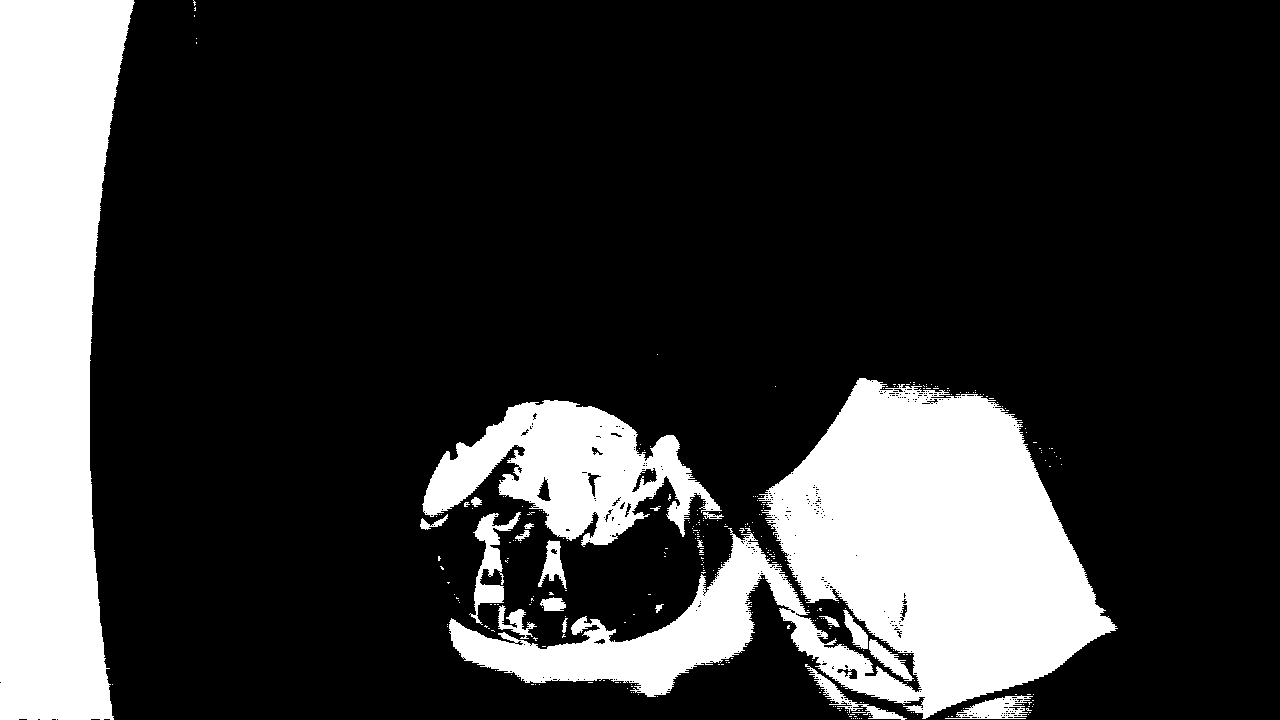

In [22]:
from pynq.lib.iic import *
from pynq import Overlay, allocate
from time import sleep
import numpy as np
import cffi

#TODO replace axi_iic_0 with axi_iic
class ov5640:
        
        __iic_device_addr = 0x64
        __cam_device_id = 0x78
        
        __stream_on = [
                [0xC4C0, 0x001C],
                [0xC4C3, 0x001C],
                [0xC4D7, 0x0000],
                [0xC4D5, 0x0002],
                [0xC4DA, 0x0001],
                [0xC4F0, 0x0000],
                [0xC427, 0x0003],
                [0xC427, 0x0001],
                [0xC427, 0x0000],
                [0xC426, 0x0030],
                [0xC426, 0x0010],
                [0xC426, 0x0000],
                [0xC423, 0x0080],
                [0xC431, 0x0080],
                [0x4001, 0x0007],
                [0x7c22, 0x0004],
        ]
        
        __stream_off = [
                [0x4001, 0x0006],
                [0x7c22, 0x0004],
                [0xC431, 0x0082],
                [0xC423, 0x0000],
                [0xC426, 0x0020],
                [0xC427, 0x0002],
                [0xC4C0, 0x003C],
                [0xC4C3, 0x003C],
                [0xC4D5, 0x0003],
                [0xC4DA, 0x0000],
                [0xC4D7, 0x0001],
                [0xC4F0, 0x0001],
        ]
        
        class axi_iic:
                _ffi = cffi.FFI()
                
                def __init__(self, axi_iic, dev_addr):
                        self._iic_dev = AxiIIC(axi_iic)
                        self._iic_dev_addr = dev_addr
                        
                def set_device_addr(self, addr):
                        self._iic_dev_addr = addr

                def write(self, reg, data):
                        buf = self._ffi.new("unsigned char [4]")
                        buf[0] = (reg >> 8) & 0xFF
                        buf[1] = reg & 0xFF
                        buf[2] = (data >> 8) & 0xFF
                        buf[3] = data
                        self._iic_dev.send(self._iic_dev_addr, buf, 3, option=0)
                        
                def read(self, reg):
                        buf = self._ffi.new("unsigned char [2]")
                        buf[0] = (reg >> 8) & 0xFF
                        buf[1] = reg & 0xFF
                        self._iic_dev.send(self._iic_dev_addr, buf, 2, option=0)
                        self._iic_dev.receive(self._iic_dev_addr, buf, 2, option=0)

                        return ((buf[0] << 8) | buf[1])
        
        def __init__(self, device):
                self._iic = self.axi_iic(device, self.__iic_device_addr)
                self.__init()
                self.set_mode(0)
                
                pass
        
        def __init(self):
                for val in self.__stream_on:
                        self._iic.write(val[0], val[1])
        
        def set_mode(self, mode):
                self._iic.write(0x4000, mode)
                self._iic.write(0x4001, 0x0004)
                self._iic.write(0x7c22, 0x0004)

          
class video_pipeline:
    
        class hls_filter:
                def __init__(self, device):
                        self._device = device
                        self._device.write(0x00, 0x81)
        
        class demosaic:
                def __init__(self, device):
                        self._device = device
                        self._device.write(0x10, 1280)
                        self._device.write(0x18, 720)
                        self._device.write(0x28, 3)
                        self._device.write(0x00, 0x81)
        
        class gamma:
                __gamma_reg=[]
                
                def gamma_calc(self, gamma_val):
                        for i in range(0,512):
                                self.__gamma_reg.append((int)((pow(i/512.0, 1 / gamma_val) * 512.0)))
                                
                def __init__(self, device):
                        self.gamma_calc(1.5)
                        self._device = device
                        self._device.write(0x18, 720)
                        self._device.write(0x10, 1280)
                        self._device.write(0x20, 0)
                        for i in range(0,(int)(512/4)):
                                self._device.write(0x800 + i*4,  (self.__gamma_reg[i] << 24) | (self.__gamma_reg[i+1] << 16) | (self.__gamma_reg[i+2] << 8) | (self.__gamma_reg[i+3]))
                        for i in range(0,(int)(512/4)):
                                self._device.write(0x1000 + i*4, (self.__gamma_reg[i] << 24) | (self.__gamma_reg[i+1] << 16) | (self.__gamma_reg[i+2] << 8) | (self.__gamma_reg[i+3]))
                        for i in range(0,(int)(512/4)):
                                self._device.write(0x1800 + i*4, (self.__gamma_reg[i] << 24) | (self.__gamma_reg[i+1] << 16) | (self.__gamma_reg[i+2] << 8) | (self.__gamma_reg[i+3]))
                        self._device.write(0x00, 0x81)
        
        class vdma:

                def __init__(self, device):
                        pass
                        self._device = device
                        self.__buffer = allocate(shape=(720, 1280, 4), dtype=np.uint8, cacheable=1)
                        self.__buffer1 = allocate(shape=(720, 1280, 4), dtype=np.uint8, cacheable=1)
                        self.__buffer2 = allocate(shape=(720, 1280, 4), dtype=np.uint8, cacheable=1)
#                         self._device.write(0x00, 0x04)
#                         self._device.write(0x00, 0x93)
#                         self._device.write(0x5C, self.__buffer.device_address)
#                         self._device.write(0x58, 1280 * 3)
#                         self._device.write(0x54, 1280 * 3)
#                         self._device.write(0x50, 720)
                        # self._device.write(0x30, 0x04)
                        self._device.write(0x30, 0x8B)
                        self._device.write(0xAC, self.__buffer.device_address)
                        self._device.write(0xB0, self.__buffer1.device_address)
                        self._device.write(0xB4, self.__buffer2.device_address)
                        self._device.write(0xA8, 1280 * 4)
                        self._device.write(0xA4, 1280 * 4)
                        self._device.write(0xA0, 720)
                def get_frame(self):
                        # while self._device.register_map.S2MMVDMASR.Halted != 1:
                                # pass
                        return self.__buffer
       
        def __init__(self, overlay):
                # self._vdma = self.vdma(overlay.vdma)
                self._demosaic = self.demosaic(overlay.demosaic)
                self._gamma = self.gamma(overlay.gamma)
                # self._hls_filter = self.hls_filter(overlay.sobel_0)
                          

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

# overlay = Overlay("/home/root/jupyter_notebooks/mipi/bit/kv260_3d_svm.bit", ignore_version=True)
overlay = Overlay("/home/root/jupyter_notebooks/mipi/bit/kv260_3d_svm.bit", dtbo="/home/root/jupyter_notebooks/mipi/dev.dtbo", ignore_version=True)

# overlay.ip_dict
camera = ov5640(overlay.ip_dict['axi_iic'])
vp = video_pipeline(overlay)

# vp._vdma.get_frame()
# image_without_alpha = image[:,:,:3]
# while True:
# print(vp._vdma.get_frame()[:,:,:3])
# image = Image.fromarray(vp._vdma.get_frame()[:,:,:3])
# image.rotate(180)

from pynq.lib.video import *
vdma = overlay.vdma
frameMode = VideoMode(1280, 720, 24)
vdma.readchannel.reset()
vdma.readchannel.mode = frameMode
vdma.readchannel.start()
# vdma.readchannel.readframe_async()
image = vdma.readchannel.readframe()
Image.fromarray(image).rotate(180)


# canvas = plt.gcf()
# size = canvas.get_size_inches()
# canvas.set_size_inches(size*2)
# plt.imshow(image)